In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T
from torchvision.utils import make_grid

from tqdm import tqdm
import time

In [2]:
transform = T.ToTensor()

# Loading MNIST
train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
batch_size = 64

# Creating Loaders
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

True
1
NVIDIA GeForce RTX 5060 Laptop GPU


In [8]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [9]:
import torch
import torch.nn as nn

# Just a basic Model
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
torch.manual_seed(42)
model = MNISTModel().to(device)
model

MNISTModel(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [11]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [12]:
count_parameters(model)

100352
   128
  8192
    64
   640
    10
______
109386


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
        b+=1
        X_train = X_train.to(device, non_blocking=True) # X represents Image
        y_train = y_train.to(device) # y represents Label
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {epoch:2}  batch: {b:4} [{batch_size*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(batch_size*b):7.3f}%')
        
    train_losses.append(epoch_train_loss / len(train_loader))
    train_correct.append(trn_corr.cpu())

    print(f"Total Loss in epoch {epoch} : {epoch_train_loss / len(train_loader)}")
        
    # Run the testing batches
    model.eval()
    correct = 0
    total = 0
    epoch_test_loss = 0
    
    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader, desc='Testing'):
            
            X_test = X_test.to(device) # X_test : Image
            y_test = y_test.to(device) # y_test : Label
            # print(X_test.device, y_test.device)
            
            # Apply the model
            y_val = model(X_test)
            
            # Calculate loss
            loss = criterion(y_val, y_test)
            epoch_test_loss += loss.item()

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            correct += (predicted == y_test).sum().item()
            total += y_test.size(0)
            
    test_losses.append(epoch_test_loss / len(test_loader))
    test_correct.append(tst_corr.cpu())

    print(f"Accuracy after Epoch {epoch} : {correct / total * 100:.2f}%")
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch 1/5:  66%|██████▌   | 616/938 [00:06<00:03, 101.79it/s]

epoch:  0  batch:  600 [ 38400/60000]  loss: 0.17530084  accuracy:  88.625%


Epoch 1/5: 100%|██████████| 938/938 [00:09<00:00, 94.35it/s] 


Total Loss in epoch 0 : 0.33281224005337334


Testing: 100%|██████████| 157/157 [00:00<00:00, 163.43it/s]


Accuracy after Epoch 0 : 94.82%


Epoch 2/5:  66%|██████▌   | 616/938 [00:07<00:03, 81.34it/s]

epoch:  1  batch:  600 [ 38400/60000]  loss: 0.12452495  accuracy:  95.724%


Epoch 2/5: 100%|██████████| 938/938 [00:11<00:00, 82.34it/s]


Total Loss in epoch 1 : 0.13627124429722107


Testing: 100%|██████████| 157/157 [00:01<00:00, 144.80it/s]


Accuracy after Epoch 1 : 96.55%


Epoch 3/5:  66%|██████▌   | 616/938 [00:07<00:03, 89.33it/s]

epoch:  2  batch:  600 [ 38400/60000]  loss: 0.04212345  accuracy:  97.133%


Epoch 3/5: 100%|██████████| 938/938 [00:11<00:00, 82.77it/s]


Total Loss in epoch 2 : 0.09471504635133866


Testing: 100%|██████████| 157/157 [00:00<00:00, 172.53it/s]


Accuracy after Epoch 2 : 97.01%


Epoch 4/5:  66%|██████▌   | 615/938 [00:07<00:03, 85.68it/s]

epoch:  3  batch:  600 [ 38400/60000]  loss: 0.08003671  accuracy:  97.831%


Epoch 4/5: 100%|██████████| 938/938 [00:11<00:00, 83.92it/s]


Total Loss in epoch 3 : 0.07086191692057925


Testing: 100%|██████████| 157/157 [00:00<00:00, 175.38it/s]


Accuracy after Epoch 3 : 97.25%


Epoch 5/5:  65%|██████▍   | 609/938 [00:07<00:03, 83.08it/s]

epoch:  4  batch:  600 [ 38400/60000]  loss: 0.01287381  accuracy:  98.312%


Epoch 5/5: 100%|██████████| 938/938 [00:11<00:00, 82.93it/s]


Total Loss in epoch 4 : 0.05438878143584527


Testing: 100%|██████████| 157/157 [00:00<00:00, 177.49it/s]

Accuracy after Epoch 4 : 97.58%

Duration: 60 seconds


In [21]:
# print("Model device:", next(model.parameters()).device)

accuracy = train_correct[-1].item() / len(train_data)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

accuracy = test_correct[-1].item() / len(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 98.27%
Test Accuracy: 97.58%


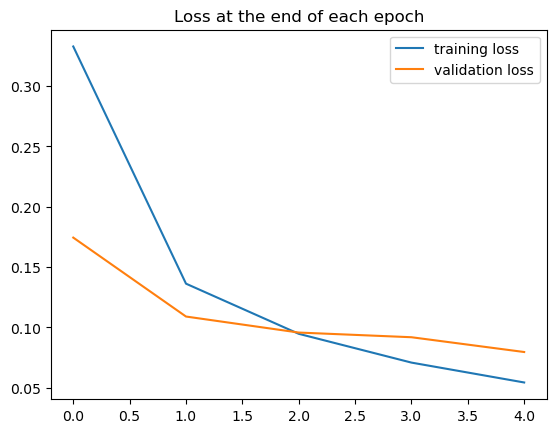

In [22]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

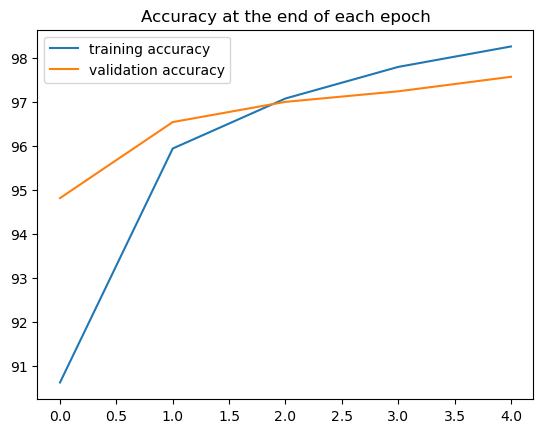

In [23]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [24]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [25]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in tqdm(test_load_all):
        
        X_test = X_test.to(device) # X_test : Image
        y_test = y_test.to(device) # y_test : Label
        
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

Test accuracy: 9758/10000 =  97.580%


In [26]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.cpu().view(-1), y_test.cpu().view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 973    0    4    0    1    4   10    1    8    3]
 [   0 1127    2    0    1    0    3    6    0    5]
 [   1    4 1009    7    2    1    2   10    5    0]
 [   1    0    3  985    0   10    1    5    9    6]
 [   1    0    3    0  958    1    4    1    3   10]
 [   0    0    0    2    0  862    3    0    4    2]
 [   0    1    2    0    4    5  934    0    2    0]
 [   0    0    6    5    3    1    0  996    4    5]
 [   2    3    3    5    3    3    1    1  937    1]
 [   2    0    0    6   10    5    0    8    2  977]]


In [27]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

242

In [28]:
# Display the first 10 index positions
misses[:10]

array([  18,  115,  149,  247,  259,  321,  340,  381,  445,  495])

In [29]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [  18  115  149  247  259  321  340  381  445  495  582  583]
Label: [   3    4    2    4    6    2    5    3    6    8    8    2]
Guess: [   8    9    4    6    0    7    3    7    0    0    2    8]


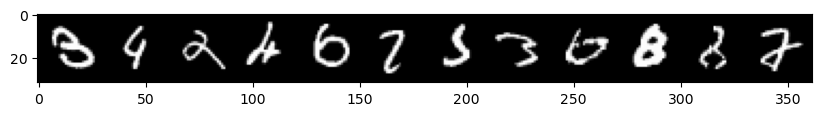

In [30]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.cpu().index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.cpu().index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.cpu().index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

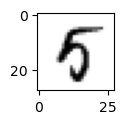

In [31]:
x = 2029
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [32]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28).to(device)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 5
